## Feature processing

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.feature_selection import f_classif, mutual_info_classif
from itertools import combinations
from scipy.stats import ttest_ind

In [2]:
# убираем предупреждения
import warnings

warnings.filterwarnings('ignore')

In [3]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [4]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [5]:
# загрузка обработанного датасета
bgg_df = pd.read_csv('data/bgg_data_full_eda.csv')

In [6]:
bgg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168507 entries, 0 to 168506
Data columns (total 72 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   name                     168507 non-null  object 
 1   description              168507 non-null  object 
 2   rating                   168507 non-null  float64
 3   bayes_rating             168507 non-null  float64
 4   usersrated               168507 non-null  int64  
 5   bggrank                  168507 non-null  int64  
 6   stddev                   168507 non-null  float64
 7   owned                    168507 non-null  int64  
 8   trading                  168507 non-null  int64  
 9   wanting                  168507 non-null  int64  
 10  wishing                  168507 non-null  int64  
 11  numweights               168507 non-null  int64  
 12  averageweight            168507 non-null  float64
 13  yearpublished            168507 non-null  int64  
 14  minp

In [7]:
# Создадим списки признаков в зависимости от их типа:

# категориальные признаки
cols_cat = ['cat_userstar', 'cat_weight', 'cat_yearpub']
# бинарные признаки
cols_bin = ['card_name', 'battle_name', 'board_game_name',
            'game', 'monopoly', 'expansion',
            'war', 'king', 'second edition',
            'expansion pack', 'dice', 'card_d',
            'game_d', 'battle_d', 'one',
            'bord', 'play', 'quot',
            'turn', 'player', 'win',
            'number', 'time', 'move',
            'rule', 'first', 'opponent',
            'cat_minplay_duel', 'cat_minplay_group', 'cat_minplay_not players',
            'cat_minplay_party', 'cat_minplay_solo', 'cat_play_duel',
            'cat_play_group', 'cat_play_not players', 'cat_play_party',
            'cat_play_solo']
# числовые признаки
cols_num = ['usersrated', 'bggrank', 'stddev',
            'owned', 'trading', 'wanting',
            'wishing', 'numweights', 'averageweight',
            'yearpublished', 'minplayers', 'maxplayers',
            'minplaytime', 'age', 'len_name',
            'len_description', 'playtime', 'bayes_rating']
# логарифмированные признаки
cols_log = ['log_usersrated', 'log_owned', 'log_trading',
            'log_wanting', 'log_wishing', 'log_numweights',
            'log_yearpublished', 'log_minplaytime', 'log_len_name',
            'log_len_description', 'log_playtime']

# информационные признаки, при обучении они нам не понадобятся
cols_inf = ['name', 'description']
# целевая переменная + возможно дублирующая переменная
col_target = ['rating']

### Расмотрим значимость признаков

**Начнем с числовых признаков.**

In [8]:
print(cols_num) # список числовых признаков

['usersrated', 'bggrank', 'stddev', 'owned', 'trading', 'wanting', 'wishing', 'numweights', 'averageweight', 'yearpublished', 'minplayers', 'maxplayers', 'minplaytime', 'age', 'len_name', 'len_description', 'playtime', 'bayes_rating']


<AxesSubplot:>

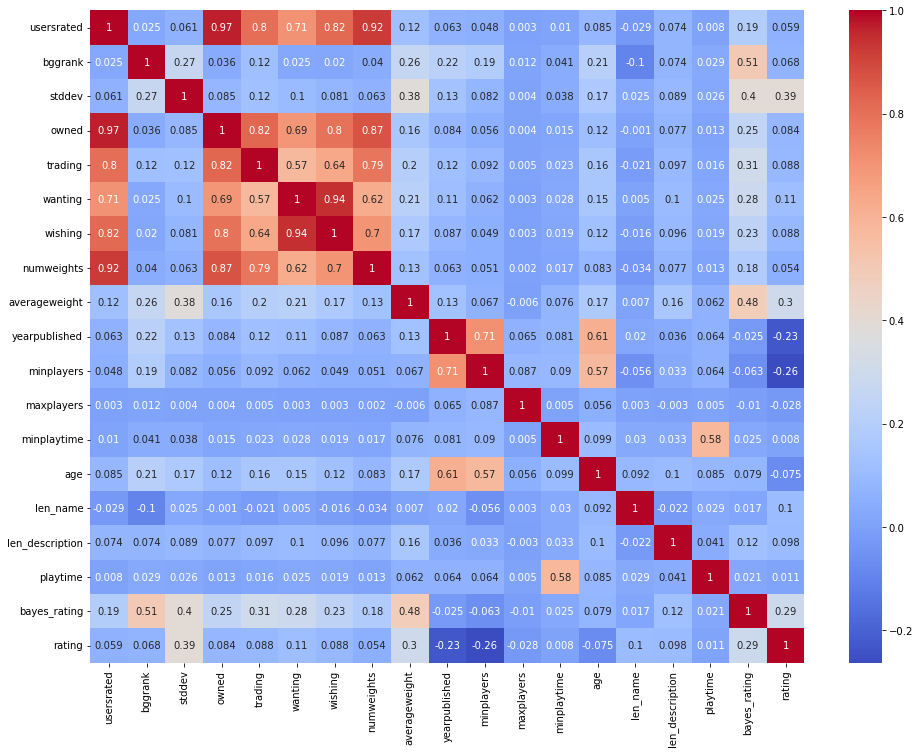

In [9]:
# посмотрим таблицу корреляции по всем числовым признакам
cor_cols_num = cols_num + col_target
correlation = bgg_df[cor_cols_num].corr(method='pearson').round(decimals=3)

plt.figure(figsize=(16, 12))
sns.heatmap(correlation, annot=True, cmap='coolwarm')

По таблице корреляции стоит удалить сильно коррелирующие признаки и самые слабо коррелирующие признаки с целевой переменной `wishing`, `usersrated`, `numweights`,`owned`, `minplaytime`, `playtime`

In [10]:
# создаем список признаков на удаление
cols_del = ['wishing', 'usersrated', 'numweights', 'owned', 'minplaytime', 'playtime']

**Посмотрим корреляцию по логарифмированныем признакам**

In [11]:
cor_cols_log = cols_log + cor_cols_num
# удаляем признаки из списка на удаление
for col in cols_del:
    cor_cols_log.remove(col)

# также удалим исходные признаки
cor_cols_log.remove('yearpublished')
cor_cols_log.remove('len_name')
cor_cols_log.remove('len_description')

<AxesSubplot:>

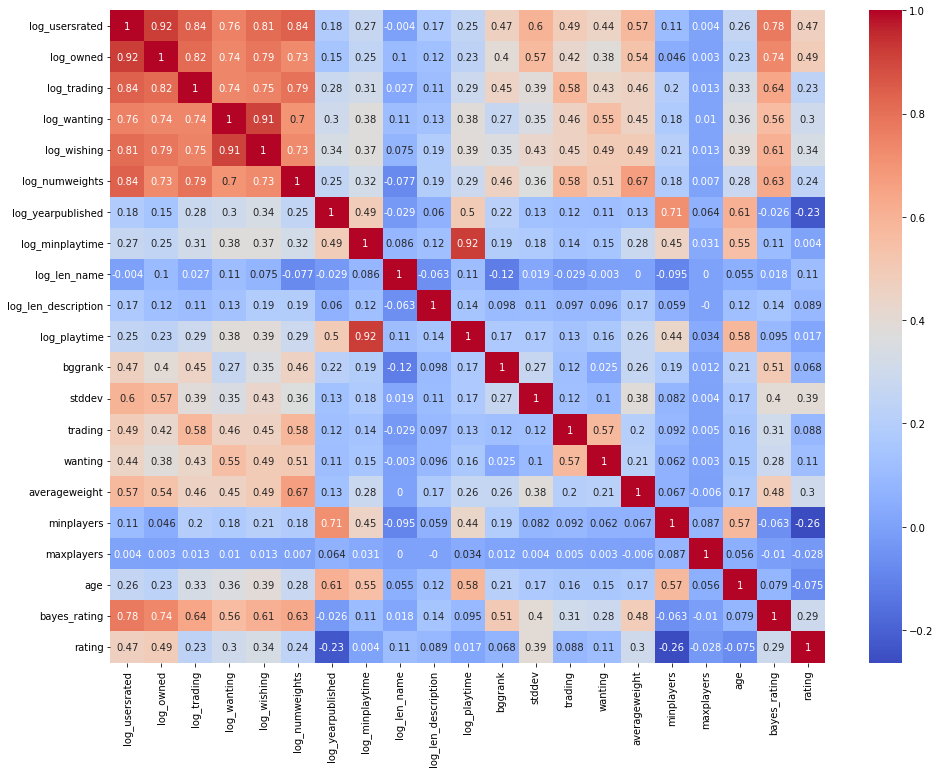

In [12]:
# посмотрим таблицу корреляции по всем логарифмированным признакам
corr_log = bgg_df[cor_cols_log].corr(method='pearson').round(decimals=3)

plt.figure(figsize=(16, 12))
sns.heatmap(corr_log, annot=True, cmap='coolwarm')

При логарифмировании стала сильнее корреляция с целевым признаком, но и между признаками корреляция увеличилась. Стоит удалить следующие признаки: `log_usersrated`, `log_wanting`, `log_minplaytime`, `log_trading`.

In [13]:
cols_del += ['log_usersrated', 'log_wanting', 'log_minplaytime', 'log_trading']

**Расмотрим корреляцию с категориальными и бинарными признаками**

In [14]:
print(cols_cat)
print(cols_bin)

['cat_userstar', 'cat_weight', 'cat_yearpub']
['card_name', 'battle_name', 'board_game_name', 'game', 'monopoly', 'expansion', 'war', 'king', 'second edition', 'expansion pack', 'dice', 'card_d', 'game_d', 'battle_d', 'one', 'bord', 'play', 'quot', 'turn', 'player', 'win', 'number', 'time', 'move', 'rule', 'first', 'opponent', 'cat_minplay_duel', 'cat_minplay_group', 'cat_minplay_not players', 'cat_minplay_party', 'cat_minplay_solo', 'cat_play_duel', 'cat_play_group', 'cat_play_not players', 'cat_play_party', 'cat_play_solo']


<AxesSubplot:>

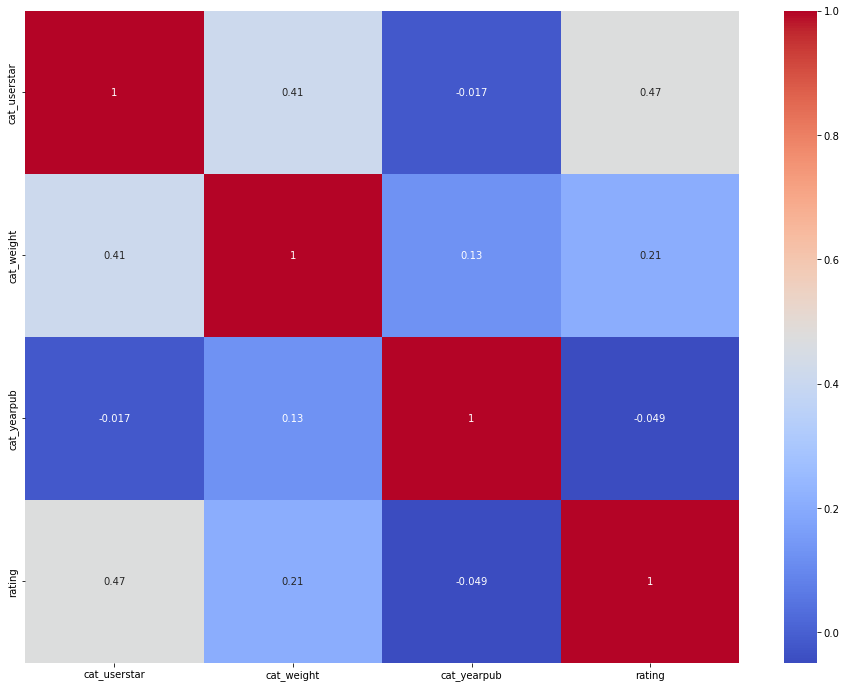

In [15]:
# посмотрим таблицу корреляции по всем категориальным признакам
cor_cols_cat = cols_cat + col_target
corr_cat = bgg_df[cor_cols_cat].corr(method='kendall').round(decimals=3)

plt.figure(figsize=(16, 12))
sns.heatmap(corr_cat, annot=True, cmap='coolwarm')

Сильно коррелируемых признаков нет.

<AxesSubplot:>

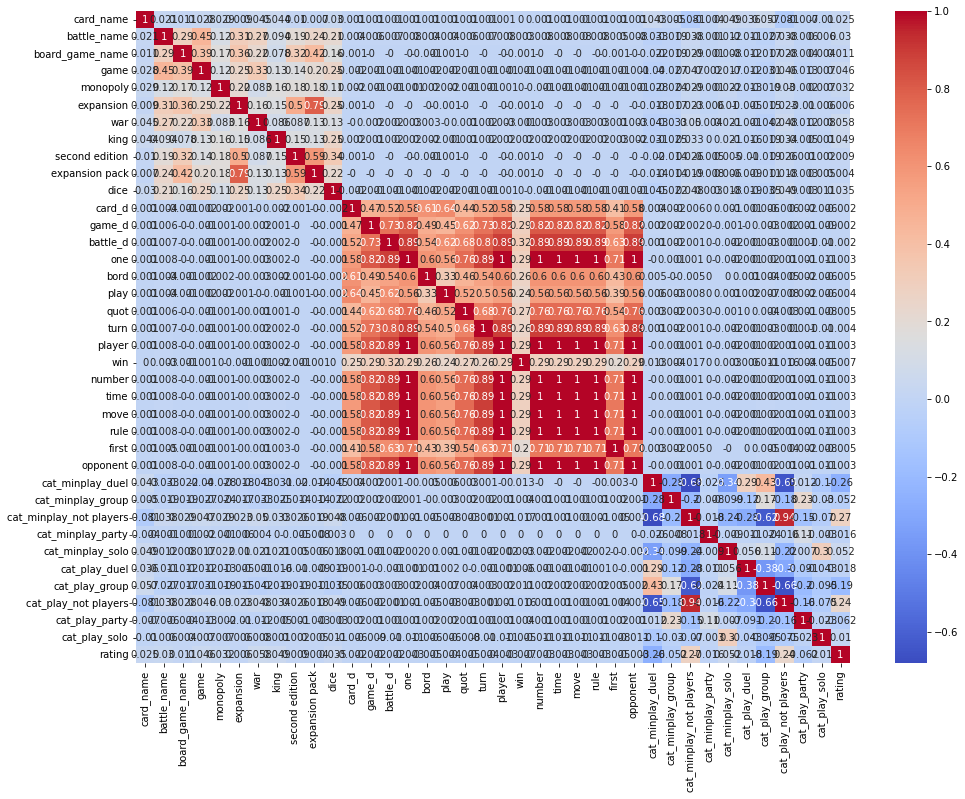

In [16]:
# посмотрим таблицу корреляции по всем бинарным признакам
cor_cols_bin = cols_bin + col_target
corr_bin = bgg_df[cor_cols_bin].corr(method='spearman').round(decimals=3)

plt.figure(figsize=(16, 12))
sns.heatmap(corr_bin, annot=True, cmap='coolwarm')

In [17]:
# удалим признаки с корреляцией близкой к 1
bgg_df.drop(['cat_minplay_not players', 'one', 'player',
             'number', 'move', 'rule', 'opponent'], axis = 1, inplace=True)

In [18]:
cols_bin.remove('cat_minplay_not players')
cols_bin.remove('one')
cols_bin.remove('player')
cols_bin.remove('number')
cols_bin.remove('move')
cols_bin.remove('rule')
cols_bin.remove('opponent')

<AxesSubplot:>

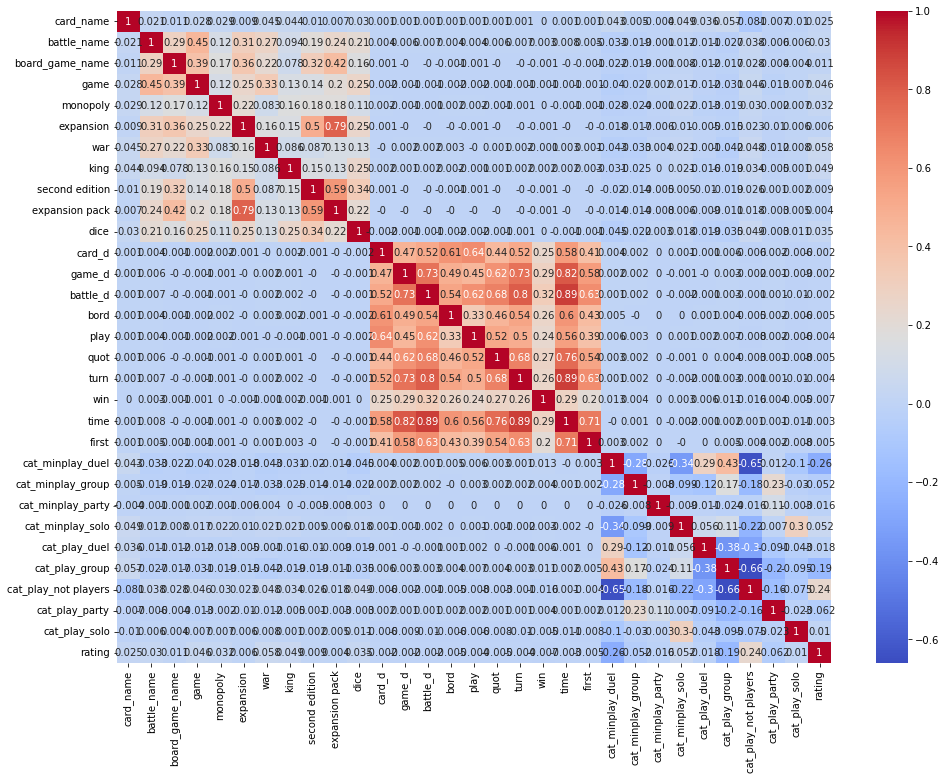

In [19]:
# посмотрим таблицу корреляции по всем бинарным признакам
cor_cols_bin = cols_bin + col_target
corr_bin = bgg_df[cor_cols_bin].corr(method='spearman').round(decimals=3)

plt.figure(figsize=(16, 12))
sns.heatmap(corr_bin, annot=True, cmap='coolwarm')

In [20]:
cols_del += ['time', 'turn', 'expansion pack']

Значимость числовых переменных по ANOVA F test

<AxesSubplot:title={'center':'Значимость непрерывных переменных по ANOVA F test'}>

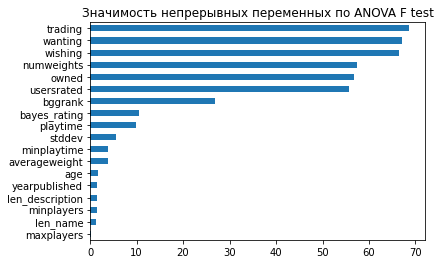

In [21]:
imp_num = pd.Series(f_classif(bgg_df[cols_num], bgg_df['rating'])[0], index = cols_num)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh', title='Значимость непрерывных переменных по ANOVA F test')

<AxesSubplot:title={'center':'Значимость непрерывных логарифмированных переменных по ANOVA F test'}>

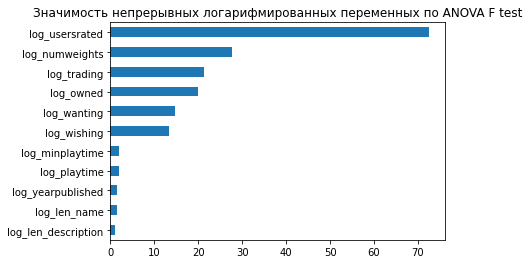

In [22]:
# для логарифмироваммых признаков
imp_num = pd.Series(f_classif(bgg_df[cols_log], bgg_df['rating'])[0], index = cols_log)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh', title='Значимость непрерывных логарифмированных переменных по ANOVA F test')

In [23]:
print(cols_del)

['wishing', 'usersrated', 'numweights', 'owned', 'minplaytime', 'playtime', 'log_usersrated', 'log_wanting', 'log_minplaytime', 'log_trading', 'time', 'turn', 'expansion pack']


Так как ANOVA F test показал, что признаки которые мы хотели удались имеют большую значимость для целевой переменной, оставим их для обучения.

In [24]:
bgg_df.drop(cols_inf, axis=1, inplace=True)

In [25]:
# Сохраняем полученные данные в файл
bgg_df.to_csv('data/bgg_data_for_ml.csv', index=False)